# Template Matching Chord Recognition, *Francesco Maccarini*

## Project for the *Audio Signals* course @ Polimi

In this notebook we aim at providing a python implementation of the chord recognition algorithm based on template matching, as presented in: "Müller, Meinard. (2015). *Fundamentals of Music Processing.* 10.1007/978-3-319-21945-5."

In [1]:
#Import valuable libraries
import numpy as np
import matplotlib.pyplot as plt
import librosa.display as dspl

### Introduction

We start by constructing the templates for major and minor triads. In chroma representation, every chord is characterized by a 1 in correspndence to those notes that are present in the chord and a 0 in correspondence to those notes that are not present in the chord.

Remember that chroma values are mapped to notes as 
\[ C, C#, D, D#, E, F, F#, G, G#, A, A#, B \]

***

**Example:** C major chord is composed by the notes C, E and G so its chorma representation will be \[ 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0 \]

In [2]:
major_labs=["C","C#","D","D#","E","F","F#","G","G#","A","A#","B"]
minor_labs=["C:min","C#:min","D:min","D#:min","E:min","F:min","F#:min","G:min","G#:min","A:min","A#:min","B:min"]
dominant7_labs=["C:7","C#:7","D:7","D#:7","E:7","F:7","F#:7","G:7","G#:7","A:7","A#:7","B:7"]
major7_labs=["C:maj7","C#:maj7","D:maj7","D#:maj7","E:maj7","F:maj7","F#:maj7","G:maj7","G#:maj7","A:maj7","A#:maj7","B:maj7"]
minor7_labs=["C:min7","C#:min7","D:min7","D#:min7","E:min7","F:min7","F#:min7","G:min7","G#:min7","A:min7","A#:min7","B:min7"]

#chords_labs=major_labs+minor_labs+dominant7_labs#+major7_labs+minor7_labs

chroma_labs=["C","C#","D","D#","E","F","F#","G","G#","A","A#","B"]

print("Major triads:")
print(major_labs)
print("Minor triads:")
print(minor_labs)
print("Major7 triads:")
print(dominant7_labs)
print("Major7 triads:")
print(major7_labs)
print("Minor7 triads:")
print(minor7_labs)
#print("Labels for possible chords:")
#print(chords_labs)

print("Chroma values (notes):")
print(chroma_labs)

Major triads:
['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
Minor triads:
['C:min', 'C#:min', 'D:min', 'D#:min', 'E:min', 'F:min', 'F#:min', 'G:min', 'G#:min', 'A:min', 'A#:min', 'B:min']
Major7 triads:
['C:7', 'C#:7', 'D:7', 'D#:7', 'E:7', 'F:7', 'F#:7', 'G:7', 'G#:7', 'A:7', 'A#:7', 'B:7']
Major7 triads:
['C:maj7', 'C#:maj7', 'D:maj7', 'D#:maj7', 'E:maj7', 'F:maj7', 'F#:maj7', 'G:maj7', 'G#:maj7', 'A:maj7', 'A#:maj7', 'B:maj7']
Minor7 triads:
['C:min7', 'C#:min7', 'D:min7', 'D#:min7', 'E:min7', 'F:min7', 'F#:min7', 'G:min7', 'G#:min7', 'A:min7', 'A#:min7', 'B:min7']
Chroma values (notes):
['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']


In [3]:
#create chroma templates for chords
#major_chords=np.zeros(shape=(12,12))
#minor_chords=np.zeros(shape=(12,12))
#dominant7_chords=np.zeros(shape=(12,12))
#major7_chords=np.zeros(shape=(12,12))
#minor7_chords=np.zeros(shape=(12,12))

#for i in range(12): #loop on possible triads
#    major_chords[(0+i)%12,i]=1
#    major_chords[(4+i)%12,i]=1
#    major_chords[(7+i)%12,i]=1
    
#    minor_chords[(0+i)%12,i]=1
#    minor_chords[(3+i)%12,i]=1
#    minor_chords[(7+i)%12,i]=1
    
#    dominant7_chords[(0+i)%12,i]=1
#    dominant7_chords[(4+i)%12,i]=1
#    dominant7_chords[(7+i)%12,i]=1
#    dominant7_chords[(10+i)%12,i]=1
    
#    major7_chords[(0+i)%12,i]=1
#    major7_chords[(4+i)%12,i]=1
#    major7_chords[(7+i)%12,i]=1
#    major7_chords[(11+i)%12,i]=1
    
#    minor7_chords[(0+i)%12,i]=1
#    minor7_chords[(3+i)%12,i]=1
#    minor7_chords[(7+i)%12,i]=1
#    minor7_chords[(10+i)%12,i]=1

#chords=np.concatenate((major_chords,minor_chords,dominant7_chords,major7_chords,minor7_chords),axis=1)
#print(chords)

It is better to have chroma representations of notes and chords that take into account the presence of harmonics. We first create a note and then sum the notes created to form chords. The paramenter $\alpha \in \left[0,1\right]$ is resposible for the intensity of the harmonics, with $\alpha=0$ we obtain the same chords as above.

In [4]:
#Chroma representation of a note (root) with harmonics
def chroma_note_harmonics(root,alpha):
    model=np.array([1+alpha+alpha**3+alpha**7,
                   0,
                   0,
                   0,
                   alpha**4,
                   0,
                   0,
                   alpha**2+alpha**5,
                   0,
                   0,
                   alpha**6,
                   0])
    chroma=np.roll(model, root)
    return chroma

In [5]:
# Chroma representation of chords with harmonics
def chroma_chords(alpha,major=True,minor=True,dominant7=True,major7=False,minor7=False):
    chords=np.zeros(shape=(12,major*12+minor*12+dominant7*12+major7*12+minor7*12))
    labs=[]
    for i in range(12): #loop on possible root notes
        if major:
            chords[:,i]=chroma_note_harmonics(root=i,alpha=alpha)+chroma_note_harmonics(root=i+4,alpha=alpha)+chroma_note_harmonics(root=i+7,alpha=alpha)
            labs=labs+major_labs
        if minor:
            chords[:,major*12+i]=chroma_note_harmonics(root=i,alpha=alpha)+chroma_note_harmonics(root=i+3,alpha=alpha)+chroma_note_harmonics(root=i+7,alpha=alpha)
            labs=labs+minor_labs
        if dominant7:
            chords[:,major*12+minor*12+i]=chroma_note_harmonics(root=i,alpha=alpha)+chroma_note_harmonics(root=i+4,alpha=alpha)+chroma_note_harmonics(root=i+7,alpha=alpha)+chroma_note_harmonics(root=i+10,alpha=alpha)
            labs=labs+dominant7_labs
        if major7:
            chords[:,major*12+minor*12+dominant7*12+i]=chroma_note_harmonics(root=i,alpha=alpha)+chroma_note_harmonics(root=i+4,alpha=alpha)+chroma_note_harmonics(root=i+7,alpha=alpha)+chroma_note_harmonics(root=i+11,alpha=alpha)
            labs=labs+major7_labs
        if minor7:
            chords[:,major*12+minor*12+dominant7*12+major7*12+i]=chroma_note_harmonics(root=i,alpha=alpha)+chroma_note_harmonics(root=i+3,alpha=alpha)+chroma_note_harmonics(root=i+7,alpha=alpha)+chroma_note_harmonics(root=i+10,alpha=alpha)
            labs=labs+minor7_labs
    return (chords,labs)

In [6]:
# Chroma chords
alpha=0.5 #must be between 0 and 1

chords,chords_labs=chroma_chords(alpha,dominant7=False)

In [7]:
def normalize_2(chroma):
    chroma=chroma/np.sqrt(np.sum(chroma**2,axis=0))
    return chroma

In [8]:
chords=normalize_2(chords)

Text(0.5, 1.0, 'Chroma representation of selected chords')

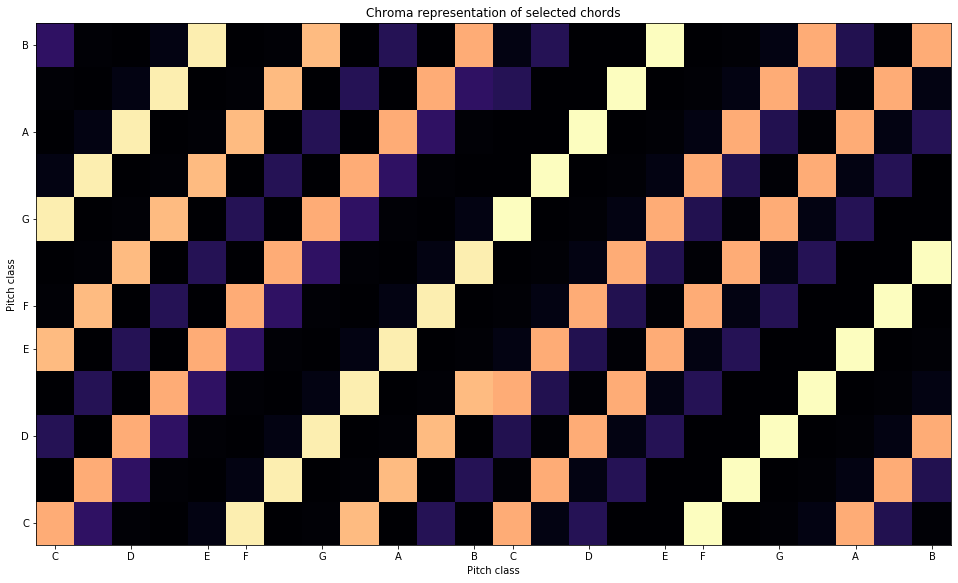

In [9]:
plt.figure(figsize=(16.4, 9.6))
g=dspl.specshow(chords, y_axis='chroma',x_axis='chroma')
#g=dspl.specshow(chords, y_axis='chroma',x_coords=chords_labs)
plt.title("Chroma representation of selected chords")

### Load audio file

In [10]:
from tkinter import filedialog
from tkinter import *

#from librosa import *
import librosa

import ntpath

import sounddevice as sd

In [11]:
# Select the file to analyze
root = Tk()
root.iconphoto(False, PhotoImage(file='play.png'))
root.filename =  filedialog.askopenfilename(initialdir = "Chord Examples",title = "Select an audio file",filetypes = (("all files","*.*"),("mp3","*.mp3"),("wav","*.wav")))
if(root.filename):
    #print ("Selected file path:",root.filename)
    name=ntpath.basename(root.filename)
    print ("Selected file name:",name)
else:
    print ("Please select a file!")
root.destroy()

Selected file name: Major_minor_triads_piano.wav


In [12]:
# Loading file with librosa
#music,sr=load(root.filename,duration=60.0)
music,sr=librosa.load(root.filename)

# WARNING: You need to have ffmpeg insalled in order to open mp3 files
# If you are using conda/anaconda runnig the following in the command prompt should fix the problem:
# conda install -c conda-forge ffmpeg

print("Sampling rate:",sr)

Sampling rate: 22050


In [13]:
# I compress the piece of music, leaving no space for dynamics
#music=librosa.mu_compress(music, quantize=False, mu=10)

Text(0.5, 1.0, 'Opened music file: Major_minor_triads_piano.wav')

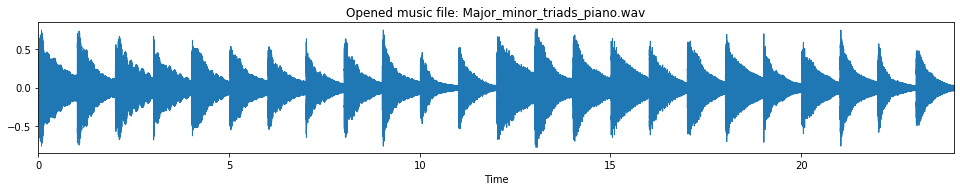

In [14]:
# Plotting waveform (just because)
plt.figure(figsize=(16.4, 2.4))
dspl.waveplot(music,sr)
plt.title("Opened music file: "+name)

In [15]:
# Play oudio
sd.play(music, sr)

In [16]:
# Ok! Stop it!
sd.stop()

### Chromagram Computation

In [17]:
import librosa.feature as feat

In [18]:
# Parameters
n_fft=2048
hop_length=512*4

#chroma=feat.chroma_cens(y=music,sr=sr,norm=2,hop_length=hop_length,smoothing_window=10)
chroma=normalize_2(feat.chroma_stft(y=music,sr=sr,norm=2,hop_length=hop_length,n_fft=n_fft,tuning=0,octwidth=None))

In [19]:
# Define a temporal smoothing for chroma vectors
def temporal_smothing(chroma,n_win):
    chroma_sm=np.zeros(shape=chroma.shape)
    chr_pd=librosa.util.pad_center(chroma,chroma.shape[1]+n_win, axis=1)
    for n in range(chroma.shape[1]):
        chroma_sm[:,n]=np.sum(chr_pd[:,n:(n+n_win)],axis=1)*1/n_win
    return chroma_sm

chroma_smooth=temporal_smothing(chroma,n_win=20)

In [20]:
sum(chroma_smooth[:,50]**2)

0.5791764539640991

In [21]:
# The function mu_compress is available only in recent versions of the package (for instance librosa 7.2, which is not the one available from conda!)
#chroma_compr = librosa.mu_compress(chroma_smooth, quantize=False, mu=30)
chroma_compr = librosa.mu_compress(chroma, quantize=False, mu=10)

chroma_compr=normalize_2(chroma_compr)

In [22]:
sum(chroma_compr[:,100]**2) # just to see if it is == 1

0.9999999344581738

Text(0.5, 1.0, 'Compressed chroma representation of Major_minor_triads_piano.wav')

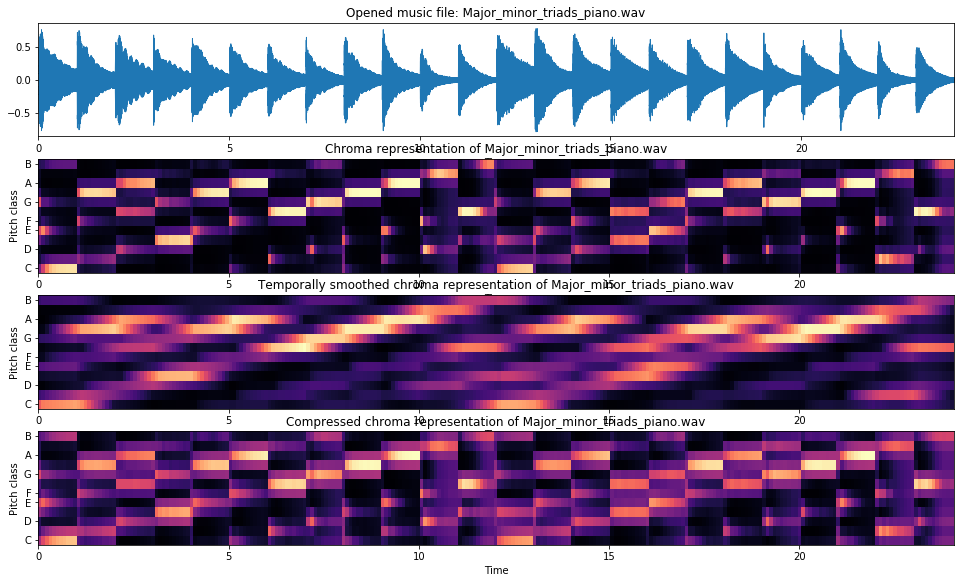

In [23]:
plt.figure(figsize=(16.4, 9.6))
plt.subplot(4,1,1)
dspl.waveplot(music,sr)
plt.title("Opened music file: "+name)
plt.subplot(4,1,2)
dspl.specshow(chroma, y_axis='chroma', x_axis='time',hop_length=hop_length)
plt.title("Chroma representation of "+name)
plt.subplot(4,1,3)
dspl.specshow(chroma_smooth, y_axis='chroma', x_axis='time',hop_length=hop_length)
plt.title("Temporally smoothed chroma representation of "+name)
plt.subplot(4,1,4)
dspl.specshow(chroma_compr, y_axis='chroma', x_axis='time',hop_length=hop_length)
plt.title("Compressed chroma representation of "+name)

In [24]:
# The right parameter mu
#plt.figure(figsize=(16.4, 16.4))
#i=0
#for mu in [1, 10, 50, 100, 150, 200, 250, 500, 1000]:
#    i=i+1
#    chroma_tmp = librosa.mu_compress(chroma_smooth,mu=mu, quantize=False)
#    plt.subplot(9,1,i)
#    dspl.specshow(chroma_tmp, y_axis='chroma', x_axis='time')
#    plt.title("Chroma representation of "+name+", compression with mu = "+str(mu))

In [25]:
def template_matching(chroma,chords,chords_labs):
    nvals=chroma.shape[1]
    nchords=chords.shape[1]
    est_chords=np.zeros(shape=nvals,dtype=int)
    est_dist=np.zeros(shape=nvals)
    dist=np.zeros(shape=nchords)
    for i in range(nvals):
        for ch in range(nchords):
            dist[ch]=np.linalg.norm(chroma[:,i]-chords[:,ch])
            est_chords[i]=np.argmin(dist)
            est_dist[i]=np.min(dist)
        #print(str(i)+"\t"+str(frames_to_time(i, sr=sr, hop_length=hop_length, n_fft=n_fft))+"\t"+str(est_chords[i])+"\t"+chords_labs[est_chords[i]])
        #print(str(frames_to_time(i, sr=sr, hop_length=hop_length)),str(frames_to_time(i+1, sr=sr, hop_length=hop_length)),chords_labs[est_chords[i]])
        #if file != None:
        #    file.write(str(frames_to_time(i, sr=sr, hop_length=hop_length))+" "+str(frames_to_time(i+1, sr=sr, hop_length=hop_length))+" "+chords_labs[est_chords[i]]+"\n")
    return (est_chords,est_dist)

In [28]:
def write_lab_file(name,est_chords,sr,hop_length,chords_labs):
    #try:
        file = open(name+".lab","w")
        beg=0
        end=0
        curr=est_chords[0]
        N_chords=1
        for i in range(len(est_chords)):
            if est_chords[i] != curr:
                end=i
                file.write(str(librosa.frames_to_time(beg, sr=sr, hop_length=hop_length))+" "+str(librosa.frames_to_time(end, sr=sr, hop_length=hop_length))+" "+chords_labs[curr]+"\n")
                beg=i
                curr=est_chords[i]
                N_chords=N_chords+1
        end=len(est_chords)
        file.write(str(librosa.frames_to_time(beg, sr=sr, hop_length=hop_length))+" "+str(librosa.frames_to_time(end, sr=sr, hop_length=hop_length))+" "+chords_labs[curr]+"\n")
        file.close()
        #print(name+".lab"+" saved in \"Analyzed_tracks/\"")
        print("Saved "+str(N_chords)+" chords to file")
    #except:
    #    print("Something went wrong!")
    

In [29]:
estimated,distance=template_matching(chroma_compr,chords,chords_labs=chords_labs)
#estimated,distance=template_matching(chroma,chords,chords_labs=chords_labs)
#estimated=template_matching(chroma_smooth,chords,chords_labs=triads_labs)
write_lab_file(name="Analyzed_tracks/"+name,est_chords=estimated,sr=sr,hop_length=hop_length,chords_labs=chords_labs)

Saved 37 chords to file


Text(0.5, 1.0, 'Distance between chroma and template vs time')

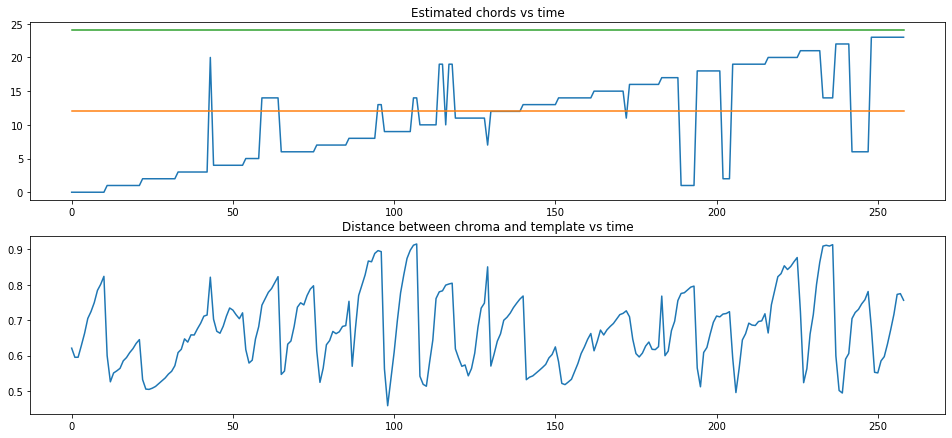

In [31]:
plt.figure(figsize=(16.4, 3.6*2))
plt.subplot(2,1,1)
plt.plot(estimated)
plt.plot(12*np.ones(shape=chroma.shape[1],dtype=int))
plt.plot(24*np.ones(shape=chroma.shape[1],dtype=int))
plt.title("Estimated chords vs time")
plt.subplot(2,1,2)
plt.plot(distance)
plt.title("Distance between chroma and template vs time")

# Selection of Hyperparameters

Although the template matching chord recognition algorithm is very simple, some degrees of freedom are left to the designer. In particular there are some hyperparameters that should be set wisely.

We decide to set some of them to standard vslues:
* **nfft**: number of samples to use in computetion of short time fourier transform. We decide to use the standard nfft $=2048$
* **hop_length**: hopsize for the computation of fft (and consequently chroma vectors). We decide to set it to hop_length $=$ nfft $=2048$

For the following, the right combination has to be found with some criteria:
* $\alpha$: parameter regulating the inclusion of harmonics in chord chroma templates
* **mu**:compression parameter
* **n_win**: number of frames to include in temporal smoothing window

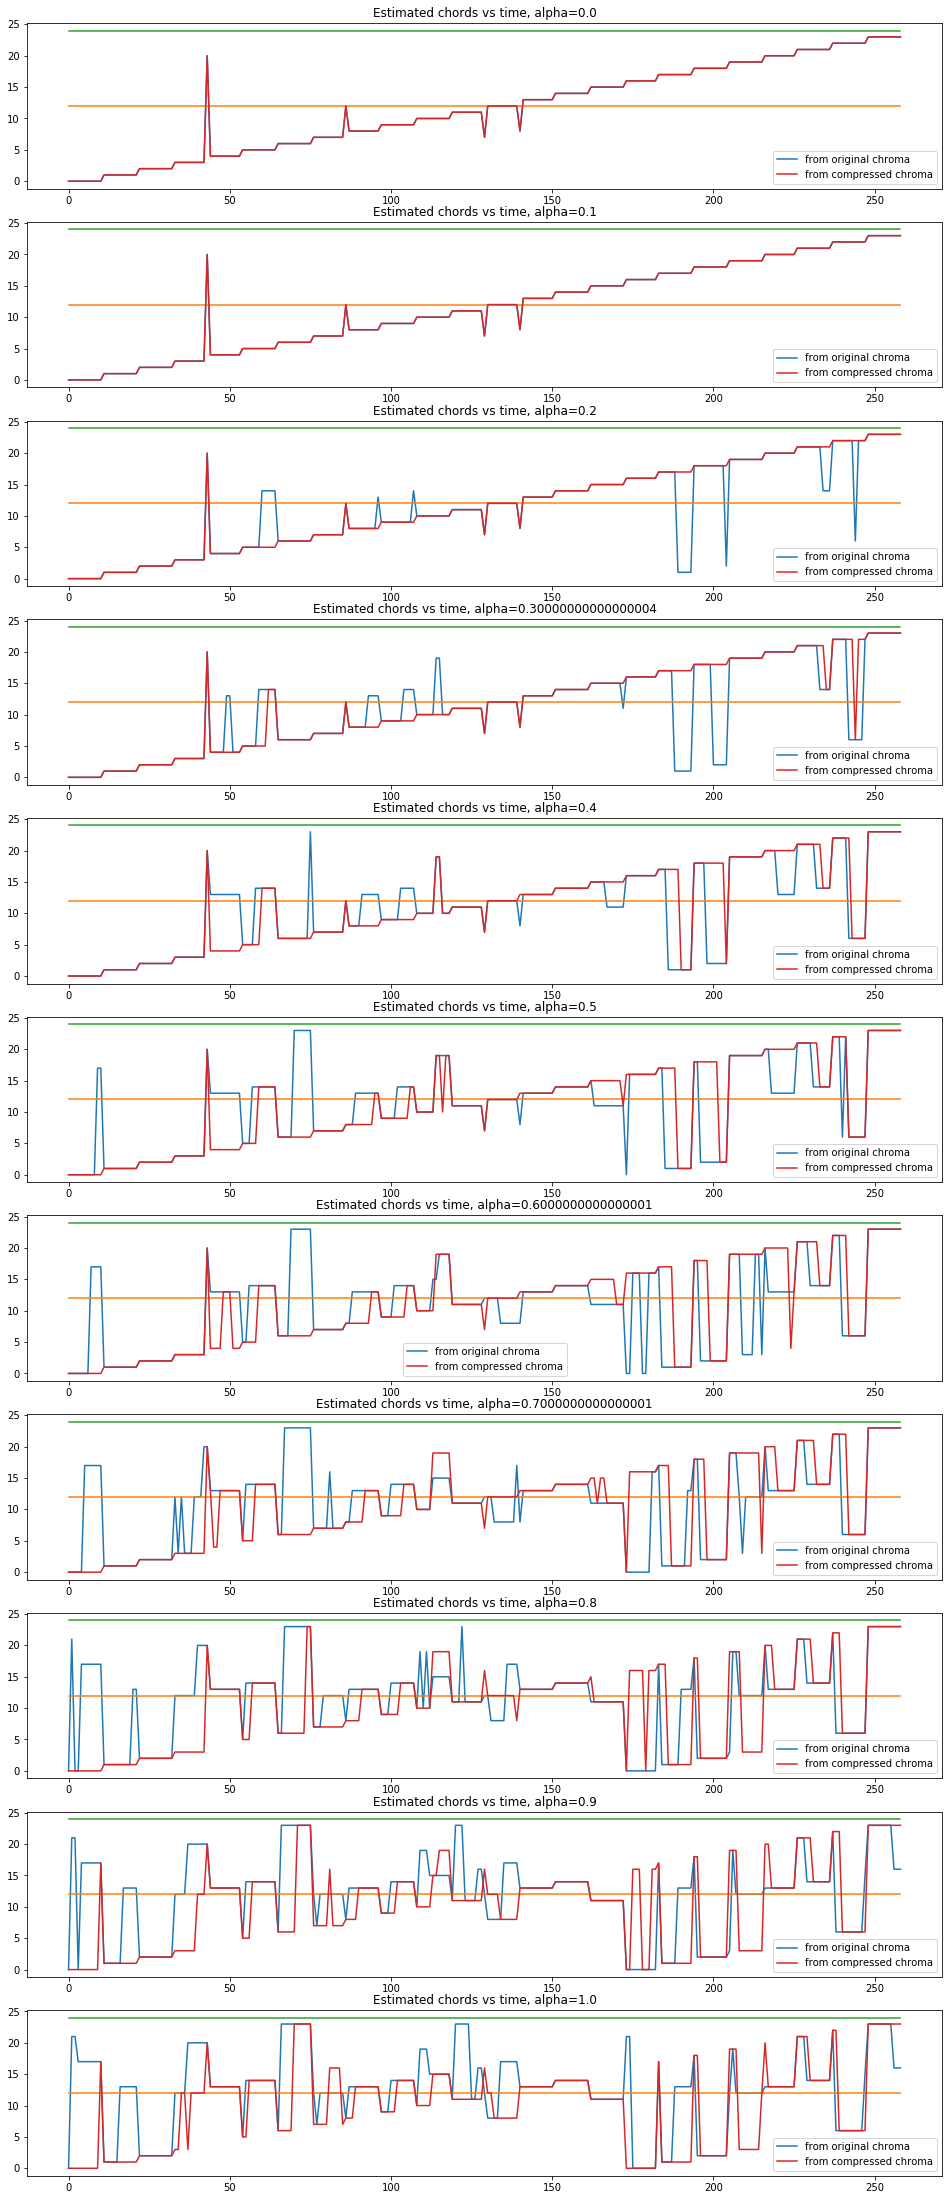

In [32]:
# Showing what happens to the estimation when alpha changes, with and without mu compression
N_steps=11
plt.figure(figsize=(16.4, 3.6*N_steps))
ii=1
for alpha in np.linspace(0,1,N_steps):
    (chords_alpha,chords_labs_alpha)=chroma_chords(alpha,dominant7=False)
    estimated,distance=template_matching(chroma,chords_alpha,chords_labs=chords_labs_alpha)
    estimated_c,distance_c=template_matching(chroma_compr,chords_alpha,chords_labs=chords_labs_alpha)
    plt.subplot(N_steps,1,ii)    
    plt.plot(estimated,label="from original chroma")
    plt.plot(12*np.ones(shape=chroma.shape[1],dtype=int))
    plt.plot(24*np.ones(shape=chroma.shape[1],dtype=int))
    plt.plot(estimated_c,label="from compressed chroma")
    plt.title("Estimated chords vs time, alpha="+str(alpha))
    plt.legend()
    ii=ii+1